# 训练模型

## 引入第三方包

In [1]:
from PIL import Image
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import *
from keras.layers import *

import glob
import pickle

import numpy as np
import tensorflow.compat.v1.gfile as gfile
import matplotlib.pyplot as plt

## 定义超参数和字符集

In [34]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
             'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
             'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   # 验证码字符集
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160        # 验证码宽度

TRAIN_DATA_DIR = './train-data/'  # 验证码数据集目录
TEST_DATA_DIR = './test-data/'

BATCH_SIZE = 100
EPOCHS = 10
OPT = 'adam'
LOSS = 'binary_crossentropy'

MODEL_DIR = './model/train_demo/'
MODEL_FORMAT = '.h5'
HISTORY_DIR = './history/train_demo/'
HISTORY_FORMAT = '.history'

filename_str = "{}captcha_{}_{}_bs_{}_epochs_{}{}"

# 模型网络结构文件
MODEL_VIS_FILE = 'captcha_classfication' + '.png'
# 模型文件
MODEL_FILE = filename_str.format(
    MODEL_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), MODEL_FORMAT)
# 训练记录文件
HISTORY_FILE = filename_str.format(
    HISTORY_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), HISTORY_FORMAT)

## 将 RGB 验证码图像转为灰度图

In [3]:
def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B
    # https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    return np.dot(img[..., :3], [0.299, 0.587, 0.114])

## 对验证码中每个字符进行 one-hot 编码

In [4]:
def text2vec(text, length=CAPTCHA_LEN, charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError(
            'Error: length of captcha should be {}, but got {}'.format(length, text_len))

    # 生成一个形如（CAPTCHA_LEN*CAPTHA_CHARSET,) 的一维向量
    # 例如，4个纯数字的验证码生成形如(4*10,)的一维向量
    vec = np.zeros(length * len(charset))
    for i in range(length):
        # One-hot 编码验证码中的每个数字
        # 每个字符的热码 = 索引 + 偏移量
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec

## 将验证码向量解码为对应字符

In [5]:
def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text

## 适配 Keras 图像数据格式

In [6]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)

    return batch, input_shape

## 读取训练集

In [7]:
X_train = []
Y_train = []
for filename in glob.glob(TRAIN_DATA_DIR + '*.png'):
    X_train.append(np.array(Image.open(filename)))
    Y_train.append(filename.lstrip(TRAIN_DATA_DIR).rstrip('.png'))

## 处理训练集图像

In [8]:
# list -> rgb(numpy)
X_train = np.array(X_train, dtype=np.float32)
# rgb -> gray
X_train = rgb2gray(X_train)
# normalize
X_train = X_train / 255
# Fit keras channels
X_train, input_shape = fit_keras_channels(X_train)

print(X_train.shape, type(X_train))
print(input_shape)

(3951, 60, 160, 1) <class 'numpy.ndarray'>
(60, 160, 1)


## 处理训练集标签

In [9]:
Y_train = list(Y_train)

for i in range(len(Y_train)):
    Y_train[i] = text2vec(Y_train[i])

Y_train = np.asarray(Y_train)

print(Y_train.shape, type(Y_train))

(3951, 40) <class 'numpy.ndarray'>


## 读取测试集，处理对应图像和标签

In [10]:
X_test = []
Y_test = []
for filename in glob.glob(TEST_DATA_DIR + '*.png'):
    X_test.append(np.array(Image.open(filename)))
    Y_test.append(filename.lstrip(TEST_DATA_DIR).rstrip('.png'))

# list -> rgb -> gray -> normalization -> fit keras
X_test = np.array(X_test, dtype=np.float32)
X_test = rgb2gray(X_test)
X_test = X_test / 255
X_test, _ = fit_keras_channels(X_test)

Y_test = list(Y_test)
for i in range(len(Y_test)):
    Y_test[i] = text2vec(Y_test[i])

Y_test = np.asarray(Y_test)

print(X_test.shape, type(X_test))
print(Y_test.shape, type(Y_test))

(970, 60, 160, 1) <class 'numpy.ndarray'>
(970, 40) <class 'numpy.ndarray'>


## 创建验证码识别模型

In [12]:
# 输入层
inputs = Input(shape=input_shape, name='inputs')

# 第1层卷积
conv1 = Conv2D(32, (3, 3), name='conv1')(inputs)
relu1 = Activation('relu', name='relu1')(conv1)

# 第2层卷积
conv2 = Conv2D(32, (3, 3), name='conv2')(relu1)
relu2 = Activation('relu', name='relu2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(relu2)

# 第3层卷积
conv3 = Conv2D(64, (3, 3), name='conv3')(pool2)
relu3 = Activation('relu', name='relu3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool3')(relu3)

# 将 Pooled feature map 摊平后输入全连接网络
x = Flatten()(pool3)

# Dropout
x = Dropout(0.25)(x)

# 4个全连接层分别做10分类，分别对应4个字符。
x = [Dense(10, activation='softmax', name='fc%d' % (i+1))(x) for i in range(4)]

# 4个字符向量拼接在一起，与标签向量形式一致，作为模型输出。
outs = Concatenate()(x)

# 定义模型的输入与输出
model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer=OPT, loss=LOSS, metrics=['accuracy'])

## 查看模型摘要

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 60, 160, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 158, 32)  320         inputs[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 58, 158, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 56, 156, 32)  9248        relu1[0][0]                      
____________________________________________________________________________________________

## 模型可视化

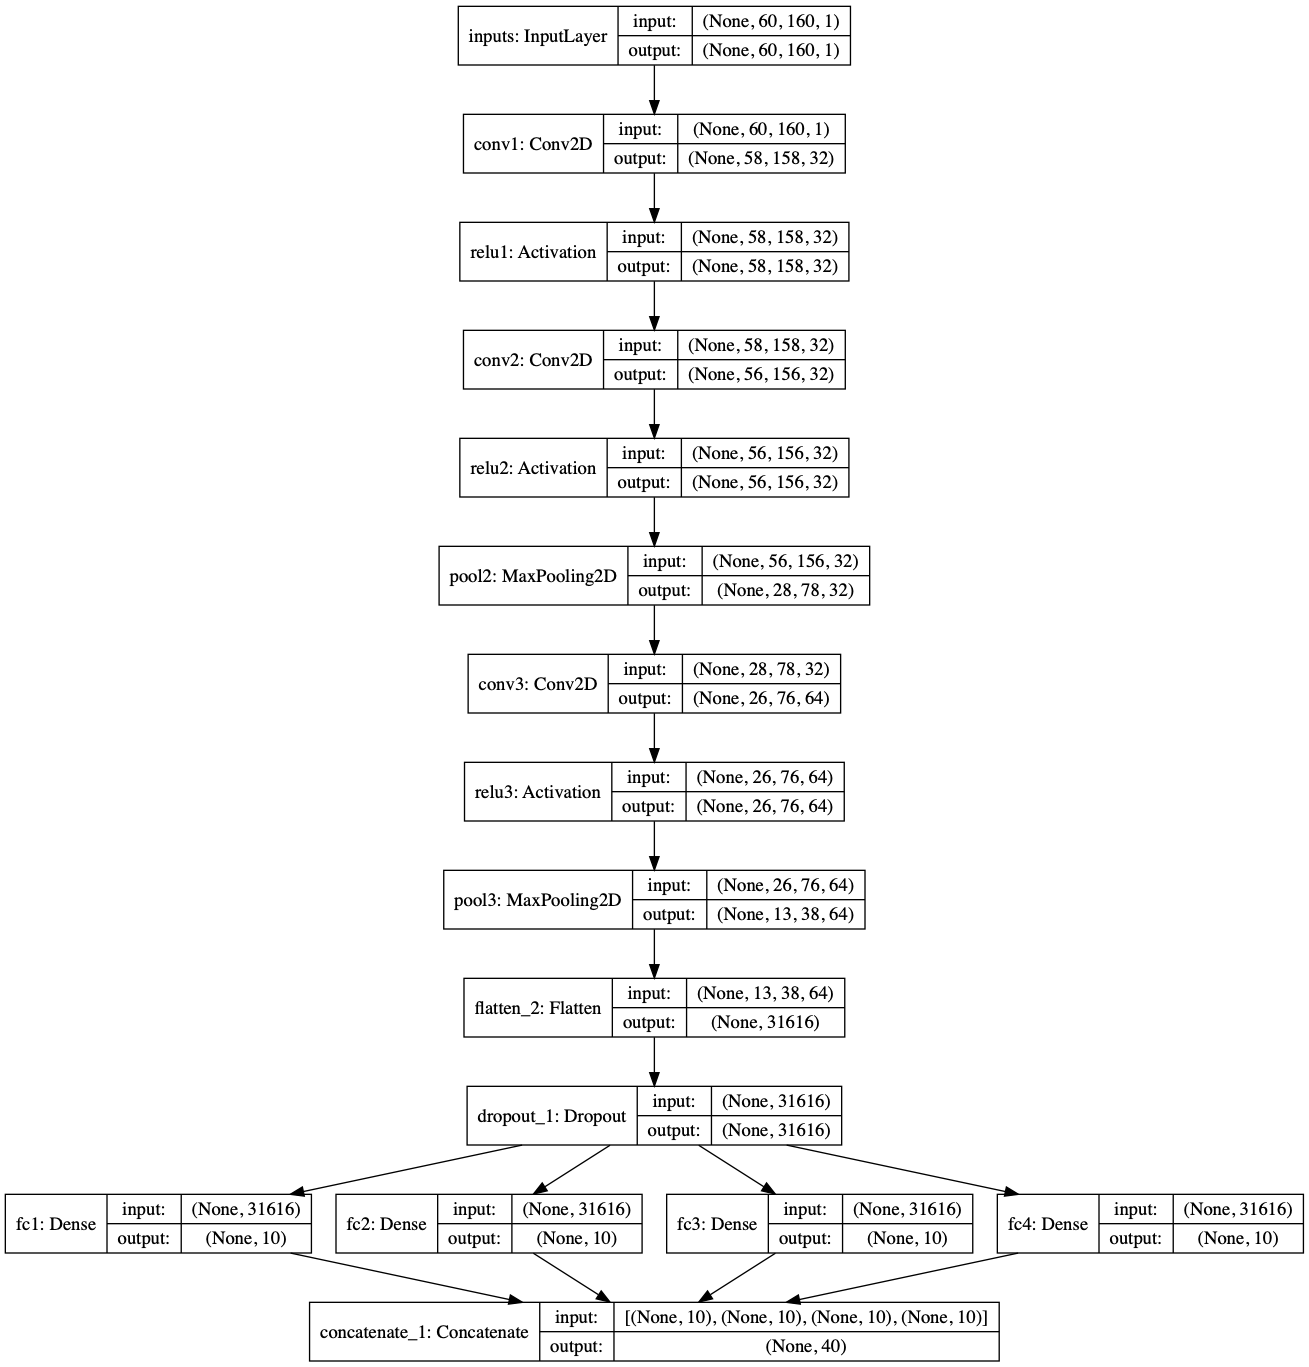

In [35]:
plot_model(model, to_file=MODEL_VIS_FILE, show_shapes=True)

## 训练模型

In [22]:
history = model.fit(X_train,
                   Y_train,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   validation_data=(X_test, Y_test))

Train on 3951 samples, validate on 970 samples
Epoch 1/10
 - 36s - loss: 0.3270 - accuracy: 0.9000 - val_loss: 0.3251 - val_accuracy: 0.9000
Epoch 2/10
 - 36s - loss: 0.3250 - accuracy: 0.9000 - val_loss: 0.3251 - val_accuracy: 0.9000
Epoch 3/10
 - 37s - loss: 0.3242 - accuracy: 0.9000 - val_loss: 0.3237 - val_accuracy: 0.9000
Epoch 4/10
 - 41s - loss: 0.3051 - accuracy: 0.9003 - val_loss: 0.2996 - val_accuracy: 0.9011
Epoch 5/10
 - 40s - loss: 0.2426 - accuracy: 0.9119 - val_loss: 0.2661 - val_accuracy: 0.9086
Epoch 6/10
 - 38s - loss: 0.1820 - accuracy: 0.9332 - val_loss: 0.2439 - val_accuracy: 0.9140
Epoch 7/10
 - 40s - loss: 0.1349 - accuracy: 0.9509 - val_loss: 0.2346 - val_accuracy: 0.9165
Epoch 8/10
 - 38s - loss: 0.0956 - accuracy: 0.9663 - val_loss: 0.2252 - val_accuracy: 0.9212
Epoch 9/10
 - 36s - loss: 0.0656 - accuracy: 0.9778 - val_loss: 0.2436 - val_accuracy: 0.9199
Epoch 10/10
 - 37s - loss: 0.0445 - accuracy: 0.9855 - val_loss: 0.2600 - val_accuracy: 0.9185


## 预测样例

In [29]:
print(vec2text(Y_test[1]))

1838


In [30]:
yy = model.predict(X_test[1].reshape(1, 60, 160, 1))

In [31]:
print(vec2text(yy))

1838


## 保存模型

In [36]:
if not gfile.Exists(MODEL_DIR):
    gfile.MakeDirs(MODEL_DIR)

model.save(MODEL_FILE)
print('Saved trained model at %s ' % MODEL_FILE)

Saved trained model at ./model/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_10.h5 


## 保存训练过程记录

In [38]:
history.history['accuracy']

[0.8999999,
 0.8999999,
 0.8999999,
 0.900272,
 0.91191465,
 0.93319416,
 0.9508796,
 0.96628076,
 0.9778285,
 0.9855163]

In [39]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [40]:
if gfile.Exists(HISTORY_DIR) == False:
    gfile.MakeDirs(HISTORY_DIR)

with open(HISTORY_FILE, 'wb') as f:
    pickle.dump(history.history, f)

In [41]:
print(HISTORY_FILE)

./history/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_10.history
